In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks'
!ls

/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks
'4.2 bioinformatics.ipynb'  '4.4 ab testing.ipynb'
'4.3 example.ipynb'	     ab_browser_test.csv
'4.3 scoring.ipynb'	     credit_card_default_analysis.csv
'4.3 tests.ipynb'	     gene_high_throughput_sequencing.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [4]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [5]:
data.shape

(566134, 6)

In [7]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [8]:
data_control = data[data['slot'] == 'control']
data_exp = data[data['slot'] == 'exp']
print(data_control.shape, data_exp.shape)
n_clicks_control = data_control['n_clicks']
n_clicks_exp = data_exp['n_clicks']
total_n_clicks_control = data_control['n_clicks'].sum()
total_n_clicks_exp = data_exp['n_clicks'].sum()
print((total_n_clicks_exp - total_n_clicks_control) / total_n_clicks_control * 100)

(284554, 6) (281580, 6)
1.6135689824415809


In [9]:
def get_bootstrap_samples(data, n_samples):
    n = data.shape[0]
    indexes = np.random.randint(0, n, (n_samples, n))
    return data[indexes]

def get_conf_interval(data, alpha=0.05):
    return np.percentile(data, [alpha * 100 / 2, (1 - alpha / 2) * 100])

In [10]:
np.random.seed(0)
bootstrap_samples_exp = get_bootstrap_samples(n_clicks_exp.values, 1000)
bootstrap_samples_control = get_bootstrap_samples(n_clicks_control.values, 1000)

In [11]:
mean_exp = np.mean(bootstrap_samples_exp, axis=1)
mean_control = np.mean(bootstrap_samples_control, axis=1)
print(get_conf_interval(mean_exp))
print(get_conf_interval(mean_control))

[11.5086867  11.66089388]
[11.20795095 11.35742732]


In [12]:
median_exp = np.median(bootstrap_samples_exp, axis=1)
median_control = np.median(bootstrap_samples_control, axis=1)
print(get_conf_interval(median_exp))
print(get_conf_interval(median_control))

[5. 5.]
[4. 4.]


In [13]:
diff_mean = mean_exp - mean_control
diff_median = median_exp - median_control
print(get_conf_interval(diff_mean))
print(get_conf_interval(diff_median))

[0.19172563 0.40475697]
[1. 1.]


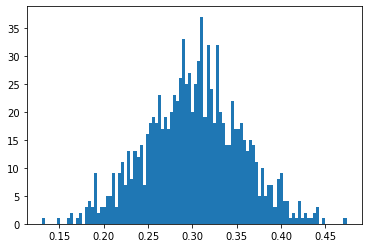

In [14]:
plt.hist(diff_mean, bins=100)
plt.show()

In [15]:
np.random.seed(0)
bootstrap_samples = get_bootstrap_samples(n_clicks_control.values, 500)

In [19]:
means = np.mean(bootstrap_samples, axis=1)
n = bootstrap_samples.shape[1]
control_boot_chi_squared = np.var(bootstrap_samples, axis = 1) * n

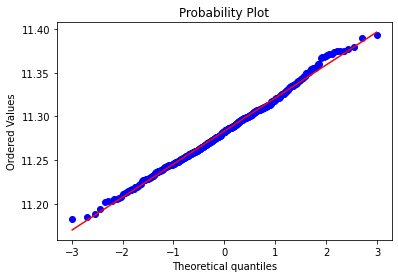

0.9979748364604202


In [20]:
res = probplot(means, dist='norm', plot=plt)
plt.show()
print(res[1][2])

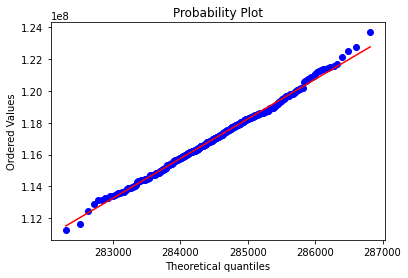

0.9982571895783731


In [21]:
res = probplot(control_boot_chi_squared, dist='chi2', sparams=(n - 1), plot=plt)
plt.show()
print(res[1][2])

In [45]:
user_clicks_control = data_control.groupby(by=['userID']).sum()['n_clicks']
user_clicks_exp = data_exp.groupby(by=['userID']).sum()['n_clicks']
stats.mannwhitneyu(user_clicks_control, user_clicks_exp, alternative='two-sided')

MannwhitneyuResult(statistic=38901259929.0, pvalue=8.694294377520879e-75)

In [48]:
pvalues = []
for browser in data['browser'].unique():
    subsample_control = data_control[data_control['browser'] == browser]['n_clicks']
    subsample_exp = data_exp[data_exp['browser'] == browser]['n_clicks']
    pvalues.append(stats.mannwhitneyu(subsample_exp, subsample_control, alternative='two-sided')[1])

print(pvalues)

[0.0544877208394482, 0.8152123531690997, 0.0, 0.07480120286021603, 0.9073331277747075, 0.5148110304420064]


In [50]:
multipletests(pvalues, alpha=0.05, method='holm')

(array([False, False,  True, False, False, False]),
 array([0.2724386 , 1.        , 0.        , 0.29920481, 1.        ,
        1.        ]),
 0.008512444610847103,
 0.008333333333333333)

In [59]:
ratio_control = data_control['n_nonclk_queries'].sum() / data_control['n_queries'].sum()
ratio_exp = data_exp['n_nonclk_queries'].sum() / data_exp['n_queries'].sum()
print(ratio_control, ratio_exp)

0.450179084208453 0.4269887343806424


In [61]:
for browser in data['browser'].unique():
    subsample_control = data_control[data_control['browser'] == browser]
    subsample_exp = data_exp[data_exp['browser'] == browser]
    ratio_control = subsample_control['n_nonclk_queries'].sum() / subsample_control['n_queries'].sum()
    ratio_exp = subsample_exp['n_nonclk_queries'].sum() / subsample_exp['n_queries'].sum()
    print(browser, ratio_exp, ratio_control, ratio_exp - ratio_control)


Browser #2 0.449827469485547 0.4596274717919465 -0.009800002306399491
Browser #4 0.4514294190358467 0.4697092963514274 -0.018279877315580673
Browser #14 0.4375561736127329 0.5759041136008114 -0.13834793998807848
Browser #17 0.3693741284866483 0.36299366746282086 0.006380461023827444
Browser #20 0.3897737648371716 0.4054048474338329 -0.01563108259666135
Browser #22 0.3985394721969546 0.40593976593513353 -0.007400293738178909
